# Neural network for h->aa->bbtautau signal/background separation

## Packages

In [1]:
import ROOT
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Activation, Dense
from keras.initializers import glorot_uniform
from keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

Welcome to JupyROOT 6.22/06


Using TensorFlow backend.


## Load root files

In [2]:
file_sig = ROOT.RDataFrame('mutau_tree', {'mt16/ggH_bbtt*.root', 'mt16/vbf_bbtt*.root'})
file_TT = ROOT.RDataFrame('mutau_tree', 'mt16/TT.root')
file_ZTT = ROOT.RDataFrame('mutau_tree', 'mt16/embedded.root')
file_obs = ROOT.RDataFrame('mutau_tree', 'mt16/data_obs.root')

files = [file_obs, file_sig, file_ZTT, file_TT]

## Define some input features

In [3]:
# define 4-vectors, invariant masses and etc.
mymu = 'ROOT::Math::PtEtaPhiMVector(pt_1,eta_1,phi_1,m_1)'
mytau = 'ROOT::Math::PtEtaPhiMVector(pt_2,eta_2,phi_2,m_2)'
mymet = 'ROOT::Math::PtEtaPhiMVector(met,0,metphi,0)'
mytt = 'ROOT::Math::PtEtaPhiMVector((mymu+mytau+mymet).Pt(),(mymu+mytau+mymet).Eta(),(mymu+mytau+mymet).Phi(),m_sv)'
myb1 = 'ROOT::Math::PtEtaPhiMVector(bpt_deepcsv_1,beta_deepcsv_1,bphi_deepcsv_1,bm_deepcsv_1)'
m_btt = '(mytt+myb1).M()'
dR_tt = 'ROOT::Math::VectorUtil::DeltaR(mymu,mytau)'
dR_bmu = 'ROOT::Math::VectorUtil::DeltaR(mymu,myb1)'
dR_btau = 'ROOT::Math::VectorUtil::DeltaR(mytau,myb1)'
m_bmu = '(mymu+myb1).M()'
m_btau = '(mytau+myb1).M()'
tt_pt = 'mytt.Pt()'
tt_eta = 'mytt.Eta()'


# define transverse masses mT and D_zeta
mT_mu = 'sqrt(pow(mymu.Pt()+mymet.Pt(),2)-pow(mymu.Px()+mymet.Px(),2)-pow(mymu.Py()+mymet.Py(),2))'
mT_tau = 'sqrt(pow(mytau.Pt()+mymet.Pt(),2)-pow(mytau.Px()+mymet.Px(),2)-pow(mytau.Py()+mymet.Py(),2))'
norm_zeta = 'sqrt(pow(mymu.Px()/mymu.Pt()+mytau.Px()/mytau.Pt(),2)+pow(mymu.Py()/mymu.Pt()+mytau.Py()/mytau.Pt(),2))'
x_zeta = '(mymu.Px()/mymu.Pt()+mytau.Px()/mytau.Pt())/norm_zeta'
y_zeta = '(mymu.Py()/mymu.Pt()+mytau.Py()/mytau.Pt())/norm_zeta'
p_zeta_mis = 'mymet.Px()*x_zeta+mymet.Py()*y_zeta'
pzeta_vis = '(mymu.Px()+mytau.Px())*x_zeta+(mymu.Py()+mytau.Py())*y_zeta'
Dzeta = 'p_zeta_mis-0.85*pzeta_vis'


# add defined variables to dataframe
for i in range(len(files)):
    files[i] = files[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('dR_tt', dR_tt)\
    .Define('m_bmu', m_bmu)\
    .Define('m_btau', m_btau)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('dR_bmu', dR_bmu)\
    .Define('dR_btau', dR_btau)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

## Apply baseline selection cuts

In [4]:
# 2016 mu+tau trigger requirements
trigger22 = '((passMu22eta2p1 && matchMu22eta2p1_1 && filterMu22eta2p1_1 && pt_1>23) or\
(passTkMu22eta2p1 && matchTkMu22eta2p1_1 && filterTkMu22eta2p1_1 && pt_1>23) or\
(passMu22 && matchMu22_1 && filterMu22_1 && pt_1>23) or\
(passTkMu22 && matchTkMu22_1 && filterTkMu22_1 && pt_1>23))'
trigger1920 = '((passMu19Tau20 && matchMu19Tau20_1 && matchMu19Tau20_2 && filterMu19Tau20_1 && filterMu19Tau20_2 && pt_1>20 && pt_1<23 && fabs(eta_2)<2.1) or\
(passMu19Tau20SingleL1 && matchMu19Tau20SingleL1_1 && matchMu19Tau20SingleL1_2 && filterMu19Tau20SingleL1_1 && filterMu19Tau20SingleL1_2 && pt_1>20 && pt_1<23 && fabs(eta_2)<2.1))'
trigger = trigger22 + str(' or ') + trigger1920


for i in range(len(files)):
    files[i] = files[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter(trigger)\
    .Filter('pt_2>25')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('q_1*q_2<0')\
    .Filter('byVLooseDeepVSe_2 && byTightDeepVSmu_2')\
    .Filter('dR_tt>0.4')\
    .Filter('bpt_deepcsv_1>20 && bscore_deepcsv_1>0.6321')

files[0] = files[0].Filter('Flag_eeBadScFilter==0')
files[2] = files[2].Filter('Flag_eeBadScFilter==0')

files[3] = files[3].Filter('gen_match_2!=6').Filter('gen_match_1<3 && gen_match_2<3')
files[1] = files[1].Filter('gen_match_2!=6')

files[2] = files[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')


# [0]=obs, [1]=sig, [2]=embedded, [3]=ttbar

## Select all input features and save into pandas DataFrame

In [5]:
# list of feature variables
feature_list = ['pt_1', 'm_btt', 'm_bmu', 'm_btau', 'tt_pt', 'tt_eta', 'mT_mu', 'mT_tau', 'Dzeta',\
                'dR_tt', 'dR_bmu', 'dR_btau', 'bpt_deepcsv_1', 'beta_deepcsv_1', 'met', 'njets']

# convert root RDataFrame into pandas DataFrame, saving only the features as columns
for i in range(len(files)):
    files[i] = pd.DataFrame(files[i].AsNumpy(feature_list))


# tag MC signal events as class 1
files[1]['label'] = np.ones((files[1].shape[0], 1))

# tag MC background events as class 0
for i in range(2, len(files)):
    files[i]['label'] = np.zeros((files[i].shape[0], 1))


for i in range(len(files)):
    print(str(files[i].shape))

(307503, 16)
(54737, 17)
(136198, 17)
(5270, 17)


## Split into MC/data

In [6]:
# reduce class 0 sample size for balanced training
files[2] = files[2].sample(n = 49467, random_state = 20)

# collect all MC as one dataframe, separated with another datafream for observed data
df_obs = files[0]
df_MC = []

for i in range(1, len(files)):
    df_MC.append(files[i])

df_MC = pd.concat(df_MC)


print('\nObserved dataframe: \n' + str(df_obs))
print('\nMC dataframe: \n' + str(df_MC))


Observed dataframe: 
             pt_1       m_btt       m_bmu      m_btau       tt_pt    tt_eta  \
0       26.482979  133.973812   17.154967   75.204529   17.936773  2.690476   
1       28.387981  212.955932   45.838167   45.845995  177.014249  0.280236   
2       26.799982  159.611748  119.425328  118.999300   46.917311 -1.080794   
3       32.350864  183.081124   97.326697   53.816370   83.924153  0.808938   
4       30.324411  126.666681   36.435984   67.587801   60.641621 -0.371219   
...           ...         ...         ...         ...         ...       ...   
307498  52.925243  552.784058  449.924262  105.898458   59.631297 -1.377070   
307499  67.011017  262.546631  143.183287  119.050893   90.698850  0.344995   
307500  53.423828  194.566780  100.968869   86.947634   78.636683 -0.195110   
307501  68.805695  219.851127  127.237113  113.803803   95.655957  0.243633   
307502  44.713158  250.102003  173.729353  182.764453   17.031387  3.188335   

             mT_mu      mT_ta

## Compare input feature distributions between sig and bkg

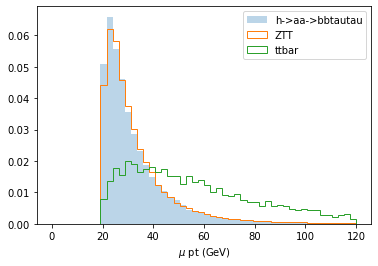

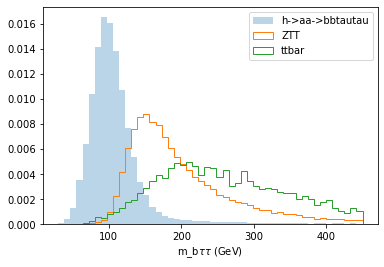

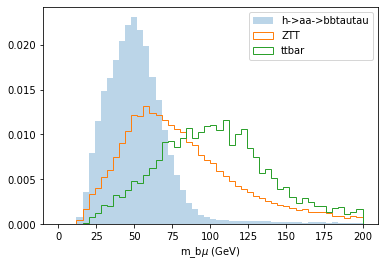

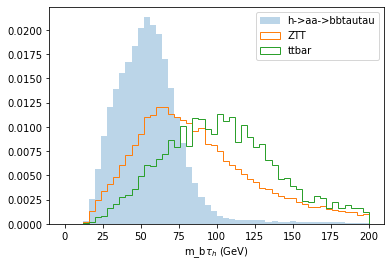

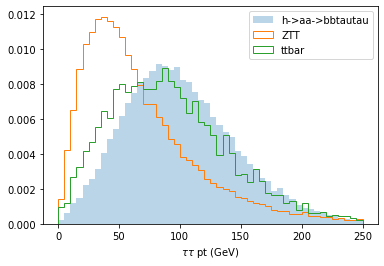

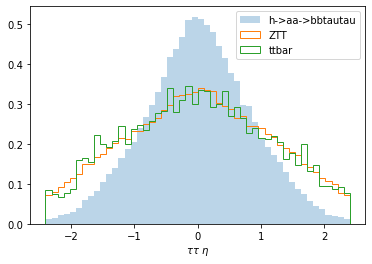

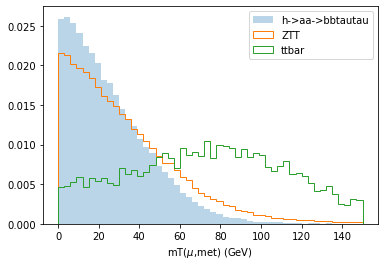

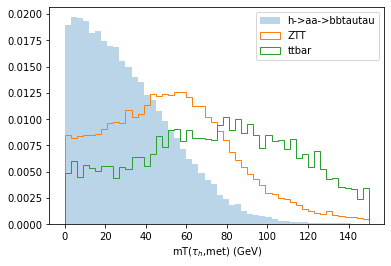

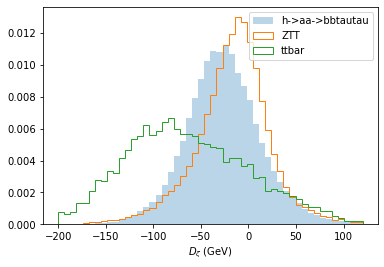

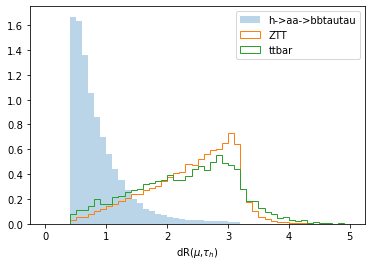

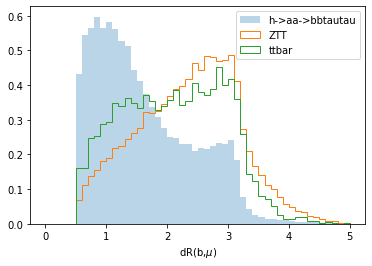

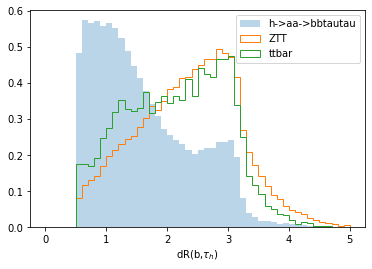

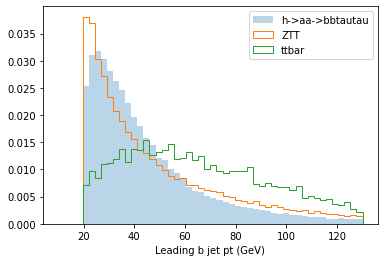

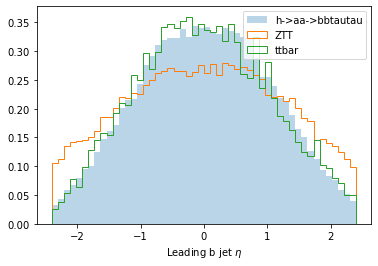

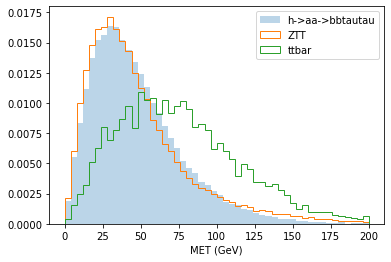

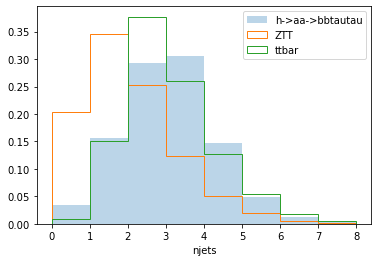

In [7]:
pyplot.hist(files[1]['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\mu$ pt (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_bmu'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['m_bmu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_bmu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$\mu$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_btau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['m_btau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_btau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$\\tau_h$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ pt (GeV)')
pyplot.show()

pyplot.hist(files[1]['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ $\eta$')
pyplot.show()

pyplot.hist(files[1]['mT_mu'], density = 1, range = (0,150), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['mT_mu'], density = 1, range = (0,150), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['mT_mu'], density = 1, range = (0,150), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\mu$,met) (GeV)')
pyplot.show()

pyplot.hist(files[1]['mT_tau'], density = 1, range = (0,150), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['mT_tau'], density = 1, range = (0,150), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['mT_tau'], density = 1, range = (0,150), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\\tau_h$,met) (GeV)')
pyplot.show()

pyplot.hist(files[1]['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$D_\zeta$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR($\mu$,$\\tau_h$)')
pyplot.show()

pyplot.hist(files[1]['dR_bmu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['dR_bmu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_bmu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b,$\mu$)')
pyplot.show()

pyplot.hist(files[1]['dR_btau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['dR_btau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_btau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b,$\\tau_h$)')
pyplot.show()

pyplot.hist(files[1]['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('Leading b jet pt (GeV)')
pyplot.show()

pyplot.hist(files[1]['beta_deepcsv_1'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['beta_deepcsv_1'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['beta_deepcsv_1'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('Leading b jet $\eta$')
pyplot.show()

pyplot.hist(files[1]['met'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['met'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['met'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('MET (GeV)')
pyplot.show()

pyplot.hist(files[1]['njets'], density = 1, range = (0,8), bins = 8, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['njets'], density = 1, range = (0,8), bins = 8, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['njets'], density = 1, range = (0,8), bins = 8, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('njets')
pyplot.show()


## Input data pre-processing

In [8]:
# convert to numpy arrays
dataset = df_MC.values
X = dataset[:,0:(dataset.shape[1]-1)]
Y = dataset[:,dataset.shape[1]-1]
Y = Y.reshape(Y.shape[0],1)

dataset_obs = df_obs.values
X_obs = dataset_obs[:,0:(dataset_obs.shape[1])]

# give train/val/test partition ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 1 - train_ratio - val_ratio

# randomly partition data set into train/val/test sets with given ratios
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size = test_ratio, random_state=15)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = val_ratio/(val_ratio+train_ratio), random_state=15)

# standardize feature variables (based on train and val sets)
scaler = StandardScaler().fit(X_train_val)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_obs = scaler.transform(X_obs)

# print input data shapes
print("X_train.shape: " + str(X_train.shape))
print("Y_train.shape: " + str(Y_train.shape))
print("X_val.shape: " + str(X_val.shape))
print("Y_val.shape: " + str(Y_val.shape))
print("X_test.shape: " + str(X_test.shape))
print("Y_test.shape: " + str(Y_test.shape))
print("\nX_obs.shape: " + str(X_obs.shape))
print("\nPartition the data set into train/val/test: %.2f/%.2f/%.2f" % (train_ratio, val_ratio, test_ratio))

# print ratio of signal/background examples in each set
train_sig = np.count_nonzero(Y_train)
train_bkg = np.count_nonzero(Y_train == 0)
train_sig_perc = 100*train_sig/(train_sig+train_bkg)
train_bkg_perc = 100*train_bkg/(train_sig+train_bkg)
val_sig = np.count_nonzero(Y_val)
val_bkg = np.count_nonzero(Y_val == 0)
val_sig_perc = 100*val_sig/(val_sig+val_bkg)
val_bkg_perc = 100*val_bkg/(val_sig+val_bkg)
test_sig = np.count_nonzero(Y_test)
test_bkg = np.count_nonzero(Y_test == 0)
test_sig_perc = 100*test_sig/(test_sig+test_bkg)
test_bkg_perc = 100*test_bkg/(test_sig+test_bkg)

total_sig = train_sig + val_sig + test_sig
total_bkg = train_bkg + val_bkg + test_bkg
total_sig_perc = 100*total_sig/(total_sig+total_bkg)
total_bkg_perc = 100*total_bkg/(total_sig+total_bkg)
print("\nTotal number of sig/bkg examples: %d/%d (%.2f%%/%.2f%%)" % (total_sig, total_bkg, total_sig_perc, total_bkg_perc))

print("\nNumber of sig/bkg examples in each set:")
print("train : %d/%d (%.1f%%/%.1f%%)" % (train_sig, train_bkg, train_sig_perc, train_bkg_perc))
print("val   : %d/%d (%.1f%%/%.1f%%)" % (val_sig, val_bkg, val_sig_perc, val_bkg_perc))
print("test  : %d/%d (%.1f%%/%.1f%%)" % (test_sig, test_bkg, test_sig_perc, test_bkg_perc))

X_train.shape: (87578, 16)
Y_train.shape: (87578, 1)
X_val.shape: (10948, 16)
Y_val.shape: (10948, 1)
X_test.shape: (10948, 16)
Y_test.shape: (10948, 1)

X_obs.shape: (307503, 16)

Partition the data set into train/val/test: 0.80/0.10/0.10

Total number of sig/bkg examples: 54737/54737 (50.00%/50.00%)

Number of sig/bkg examples in each set:
train : 43712/43866 (49.9%/50.1%)
val   : 5518/5430 (50.4%/49.6%)
test  : 5507/5441 (50.3%/49.7%)


## Neural network achitecture

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_input (InputLayer)         (None, 16)                0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 20)                340       
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 20)                420       
_________________________________________________________________
Y_output (Dense)             (None, 1)                 21        
Total params: 781
Trainable params: 781
Non-trainable params: 0
_________________________________________________________________


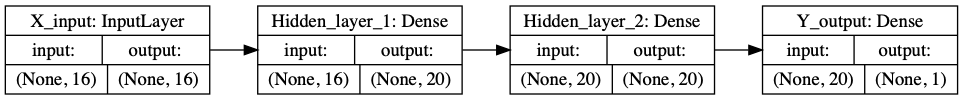

2021-01-09 21:51:39.812984: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-01-09 21:51:39.813883: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [9]:
######## input layer ########
X_input = Input(shape = (X.shape[1],), name = 'X_input')


######## hidden layers ########
hidden_1 = Dense(
    units = 20,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_1'
)(X_input)

hidden_2 = Dense(
    units = 20,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_2'
)(hidden_1)


######## output layer #######
Y_output = Dense(
    units = 1,
    activation = 'sigmoid',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Y_output'
)(hidden_2)


model = Model(inputs = X_input, outputs = Y_output)

# use adaptive moment estimation (adam) to train, which uses both GD with momentum and RMSprop
# the default hyperparameters in adam are usually good enough
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) ### accuracy = freq. of y_pred = y_true

# show model details
model.summary()

# plot model shape
plot_model(model, to_file = 'model_shape.png', rankdir = 'LR', show_shapes = True)

## Model training

In [10]:
# 1 epoch = 1 pass through the data set
# typical mini-batch size = 2^n for faster computation
history = model.fit(X_train, Y_train,
                    epochs = 50,
                    validation_data = (X_val, Y_val),
                    batch_size = 256)

Train on 87578 samples, validate on 10948 samples
Epoch 1/50
87578/87578 [==============================] - 2s 20us/step - loss: 0.2493 - accuracy: 0.9089 - val_loss: 0.1494 - val_accuracy: 0.9457
Epoch 2/50
87578/87578 [==============================] - 1s 14us/step - loss: 0.1333 - accuracy: 0.9526 - val_loss: 0.1271 - val_accuracy: 0.9551
Epoch 3/50
87578/87578 [==============================] - 1s 13us/step - loss: 0.1199 - accuracy: 0.9568 - val_loss: 0.1208 - val_accuracy: 0.9568
Epoch 4/50
87578/87578 [==============================] - 1s 12us/step - loss: 0.1144 - accuracy: 0.9588 - val_loss: 0.1173 - val_accuracy: 0.9586
Epoch 5/50
87578/87578 [==============================] - 1s 13us/step - loss: 0.1115 - accuracy: 0.9594 - val_loss: 0.1147 - val_accuracy: 0.9604
Epoch 6/50
87578/87578 [==============================] - 1s 12us/step - loss: 0.1094 - accuracy: 0.9600 - val_loss: 0.1131 - val_accuracy: 0.9610
Epoch 7/50
87578/87578 [==============================] - 1s 13us/st

## Training/validation performance plots

Text(0, 0.5, 'Accuracy (y_pred = y_true)')

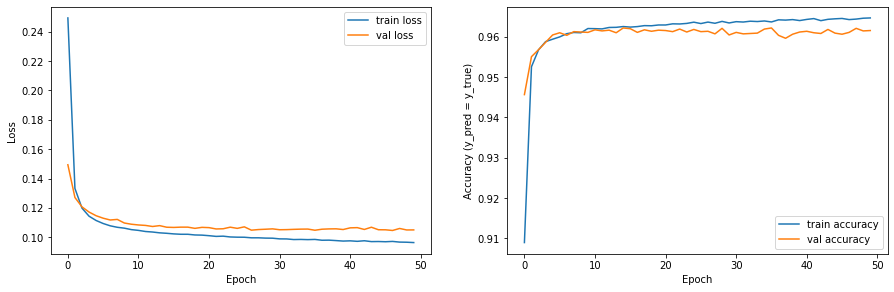

In [12]:
# plot loss vs epoch
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

# plot accuracy vs epoch
axes = plt.subplot(2, 2, 2)
axes.plot(history.history['accuracy'], label = 'train accuracy')
axes.plot(history.history['val_accuracy'], label = 'val accuracy')
axes.legend(loc = "lower right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Accuracy (y_pred = y_true)')

## Partition the test set into sig/bkg sets

In [13]:
# count sig/bkg examples in the test set
test_sig_number = np.count_nonzero(Y_test)
test_bkg_number = np.count_nonzero(Y_test == 0)

X_test_sig = np.zeros((test_sig_number,X_test.shape[1]))
X_test_bkg = np.zeros((test_bkg_number,X_test.shape[1]))

j = 0
k = 0
for i in range(Y_test.shape[0]):
    if Y_test[i,0] == 1:
        X_test_sig[j,:] = X_test[i,:]
        j = j + 1
    else:
        X_test_bkg[k,:] = X_test[i,:]
        k = k + 1

## Test set performance plots

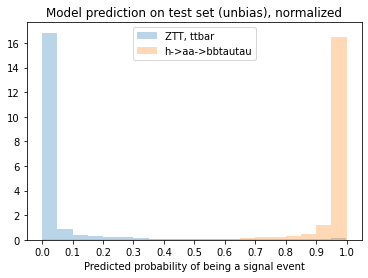

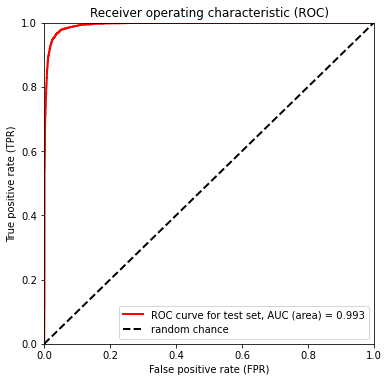

Test loss, test accuracy: [0.10032901336644137, 0.9640116691589355]


In [14]:
pyplot.hist(model.predict(X_test_bkg), density = 1, bins = 20, alpha = 0.3, label = 'ZTT, ttbar')
pyplot.hist(model.predict(X_test_sig), density = 1, bins = 20, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.legend(loc = 'upper center')
pyplot.title('Model prediction on test set (unbias), normalized')
pyplot.xlabel('Predicted probability of being a signal event')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.show()

# Plot ROC
plt.figure(figsize = (13,13))
Y_predict = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
axes = plt.subplot(2, 2, 1)
axes.plot(fpr, tpr, lw = 2, color = 'red', label = 'ROC curve for test set, AUC (area) = %.3f' % (roc_auc))
axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
axes.set_xlabel('False positive rate (FPR)')
axes.set_ylabel('True positive rate (TPR)')
axes.set_title('Receiver operating characteristic (ROC)')
axes.legend(loc = "lower right")
plt.show()

results = model.evaluate(X_test, Y_test, verbose = 0, batch_size = 512)
print("Test loss, test accuracy:", results)

## Prediction on the observed data set

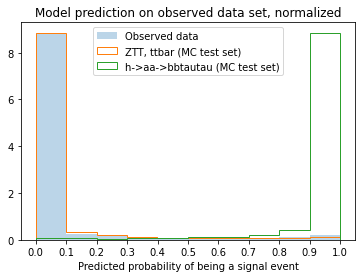

In [15]:
pyplot.hist(model.predict(X_obs), density = 1, bins = 10, alpha = 0.3, label = 'Observed data')
pyplot.hist(model.predict(X_test_bkg), density = 1, bins = 10, alpha = 1.0, label = 'ZTT, ttbar (MC test set)', histtype = 'step')
pyplot.hist(model.predict(X_test_sig), density = 1, bins = 10, alpha = 1.0, label = 'h->aa->bbtautau (MC test set)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Model prediction on observed data set, normalized')
pyplot.xlabel('Predicted probability of being a signal event')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.show()